In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


**PART 1**

Epoch 1/15 | Loss 1.315 | Accuracy 52.96%
Epoch 2/15 | Loss 0.906 | Accuracy 68.46%
Epoch 3/15 | Loss 0.746 | Accuracy 74.39%
Epoch 4/15 | Loss 0.639 | Accuracy 77.88%
Epoch 5/15 | Loss 0.558 | Accuracy 80.74%
Epoch 6/15 | Loss 0.491 | Accuracy 82.82%
Epoch 7/15 | Loss 0.427 | Accuracy 85.32%
Epoch 8/15 | Loss 0.370 | Accuracy 87.17%
Epoch 9/15 | Loss 0.325 | Accuracy 88.67%
Epoch 10/15 | Loss 0.279 | Accuracy 90.19%
Epoch 11/15 | Loss 0.243 | Accuracy 91.42%
Epoch 12/15 | Loss 0.214 | Accuracy 92.42%
Epoch 13/15 | Loss 0.185 | Accuracy 93.51%
Epoch 14/15 | Loss 0.156 | Accuracy 94.53%
Epoch 15/15 | Loss 0.149 | Accuracy 94.61%


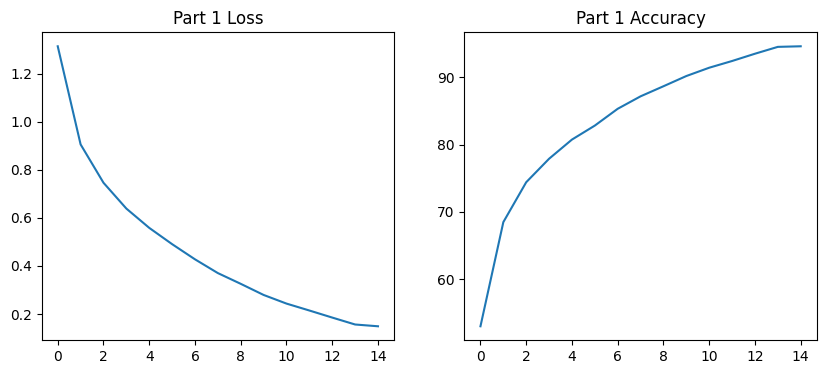

In [ ]:
# DATA
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2470, 0.2435, 0.2616)
    )
])

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


# MODEL
class CNN_Part1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(128*4*4, 10)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


model = CNN_Part1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# TRAIN
epochs = 15
losses, accs = [], []

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total

    losses.append(epoch_loss)
    accs.append(epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss {epoch_loss:.3f} | Accuracy {epoch_acc:.2f}%")


# PLOT
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("Part 1 Loss")

plt.subplot(1,2,2)
plt.plot(accs)
plt.title("Part 1 Accuracy")
plt.show()


In [ ]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print("Part 1 Test Accuracy:", 100 * correct / total)


Part 1 Test Accuracy: 64.51


**PART 2**

Epoch 1/10 | Accuracy 40.37%
Epoch 2/10 | Accuracy 52.51%
Epoch 3/10 | Accuracy 56.90%
Epoch 4/10 | Accuracy 60.28%
Epoch 5/10 | Accuracy 62.80%
Epoch 6/10 | Accuracy 64.70%
Epoch 7/10 | Accuracy 66.17%
Epoch 8/10 | Accuracy 67.81%
Epoch 9/10 | Accuracy 68.75%
Epoch 10/10 | Accuracy 69.74%


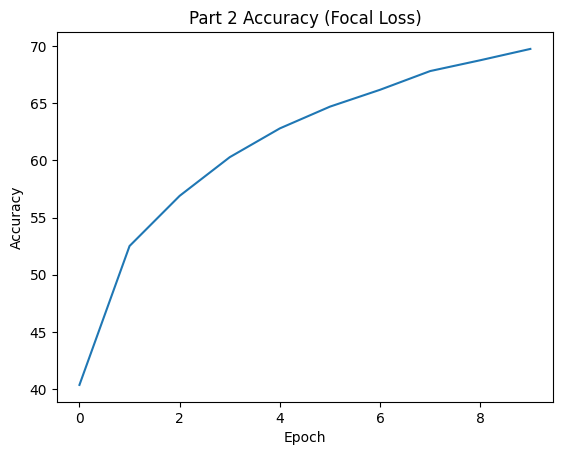

In [ ]:
# MODEL
class CNN_Part2(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(64*8*8, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# FOCAL LOSS
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        ce = self.ce(outputs, targets)
        pt = torch.exp(-ce)
        return (1 - pt) ** self.gamma * ce


model = CNN_Part2().to(device)
criterion = FocalLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


# TRAIN
epochs = 10
losses, accs = [], []

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_acc = 100 * correct / total
    accs.append(epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} | Accuracy {epoch_acc:.2f}%")


# PLOT
plt.plot(accs)
plt.title("Part 2 Accuracy (Focal Loss)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


**PART 3**

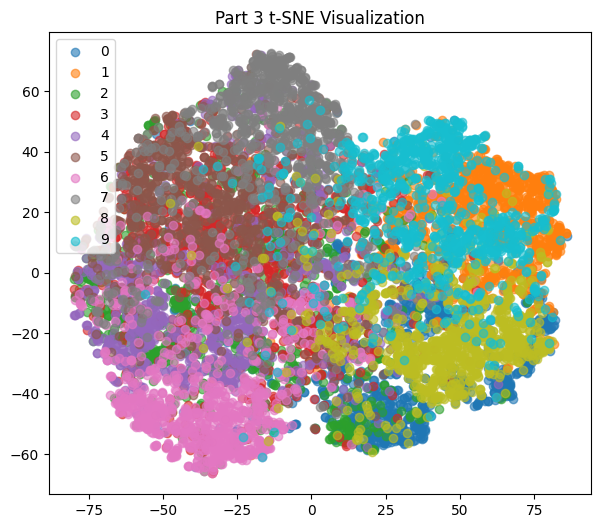

In [ ]:
model.eval()
features, labels = [], []

with torch.no_grad():
    for images, lbls in testloader:
        images = images.to(device)
        outputs = model(images)
        features.append(outputs.cpu().numpy())
        labels.append(lbls.numpy())

features = np.concatenate(features)
labels = np.concatenate(labels)

tsne = TSNE(n_components=2, random_state=42)
reduced = tsne.fit_transform(features)

plt.figure(figsize=(7,6))
for i in range(10):
    plt.scatter(
        reduced[labels == i, 0],
        reduced[labels == i, 1],
        label=str(i),
        alpha=0.6
    )
plt.legend()
plt.title("Part 3 t-SNE Visualization")
plt.show()


In [ ]:
# MNIST (simple, balanced)
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=mnist_transform)
mnist_test = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=mnist_transform)

mnist_trainloader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_testloader = DataLoader(mnist_test, batch_size=64, shuffle=False)


# CIFAR-10 (complex, noisy)
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2470, 0.2435, 0.2616)
    )
])

cifar_train = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=cifar_transform)
cifar_test = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=cifar_transform)

cifar_trainloader = DataLoader(cifar_train, batch_size=64, shuffle=True)
cifar_testloader = DataLoader(cifar_test, batch_size=64, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.71MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.40MB/s]
100%|██████████| 170M/170M [00:03<00:00, 44.2MB/s]


In [ ]:
def train_test(model, trainloader, testloader, optimizer, criterion, epochs):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0

        for x, y in trainloader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            _, pred = out.max(1)
            total += y.size(0)
            correct += pred.eq(y).sum().item()

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {100*correct/total:.2f}%")

    # TEST
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = out.max(1)
            total += y.size(0)
            correct += pred.eq(y).sum().item()

    print("Test Accuracy:", 100*correct/total)


In [ ]:
class VGGStyleMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 28 → 14

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)    # 14 → 7
        )
        self.fc = nn.Linear(64*7*7, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


model = VGGStyleMNIST().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_test(
    model,
    mnist_trainloader,
    mnist_testloader,
    optimizer,
    criterion,
    epochs=10
)


Epoch 1/10 | Train Acc: 95.68%
Epoch 2/10 | Train Acc: 98.52%
Epoch 3/10 | Train Acc: 98.95%
Epoch 4/10 | Train Acc: 99.16%
Epoch 5/10 | Train Acc: 99.39%
Epoch 6/10 | Train Acc: 99.46%
Epoch 7/10 | Train Acc: 99.55%
Epoch 8/10 | Train Acc: 99.64%
Epoch 9/10 | Train Acc: 99.70%
Epoch 10/10 | Train Acc: 99.72%
Test Accuracy: 99.1


In [ ]:
class AlexNetSmall(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(192*8*8, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.ce = nn.CrossEntropyLoss()
        self.gamma = gamma

    def forward(self, outputs, targets):
        ce = self.ce(outputs, targets)
        pt = torch.exp(-ce)
        return (1 - pt)**self.gamma * ce


model = AlexNetSmall().to(device)
criterion = FocalLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

train_test(model, cifar_trainloader, cifar_testloader,
           optimizer, criterion, epochs=20)


Epoch 1/20 | Train Acc: 43.92%
Epoch 2/20 | Train Acc: 55.99%
Epoch 3/20 | Train Acc: 61.00%
Epoch 4/20 | Train Acc: 64.24%
Epoch 5/20 | Train Acc: 66.46%
Epoch 6/20 | Train Acc: 68.11%
Epoch 7/20 | Train Acc: 69.78%
Epoch 8/20 | Train Acc: 70.99%
Epoch 9/20 | Train Acc: 71.90%
Epoch 10/20 | Train Acc: 73.16%
Epoch 11/20 | Train Acc: 73.99%
Epoch 12/20 | Train Acc: 74.69%
Epoch 13/20 | Train Acc: 75.56%
Epoch 14/20 | Train Acc: 76.36%
Epoch 15/20 | Train Acc: 77.11%
Epoch 16/20 | Train Acc: 77.68%
Epoch 17/20 | Train Acc: 78.40%
Epoch 18/20 | Train Acc: 79.04%
Epoch 19/20 | Train Acc: 79.63%
Epoch 20/20 | Train Acc: 80.12%
Test Accuracy: 66.22


In [ ]:
from torchvision.models import resnet18

class ArcFaceLoss(nn.Module):
    def __init__(self, s=30.0, m=0.5):
        super().__init__()
        self.ce = nn.CrossEntropyLoss()
        self.s = s
        self.m = m

    def forward(self, logits, labels):
        logits = logits - self.m
        return self.ce(self.s * logits, labels)


model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 10)

criterion = ArcFaceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_test(model, cifar_trainloader, cifar_testloader,
           optimizer, criterion, epochs=15)


Epoch 1/15 | Train Acc: 34.25%
Epoch 2/15 | Train Acc: 37.90%
Epoch 3/15 | Train Acc: 32.18%
Epoch 4/15 | Train Acc: 36.86%
Epoch 5/15 | Train Acc: 41.34%
Epoch 6/15 | Train Acc: 42.65%
Epoch 7/15 | Train Acc: 44.77%
Epoch 8/15 | Train Acc: 39.42%
Epoch 9/15 | Train Acc: 41.08%
Epoch 10/15 | Train Acc: 47.47%
Epoch 11/15 | Train Acc: 49.01%
Epoch 12/15 | Train Acc: 53.11%
Epoch 13/15 | Train Acc: 57.76%
Epoch 14/15 | Train Acc: 58.62%
Epoch 15/15 | Train Acc: 63.30%
Test Accuracy: 62.37
